# **Group - 21**

1) Raghav Bhalla (2019379)

2) Ritesh Panwar (2019384) 

# **Deep CNN -  VGG16 Model**

For similar landmark image retrieval

In [ ]:
#Mounting Google Drive to Notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import random
from urllib.parse import urlparse
from scipy.spatial.distance import cityblock
import cv2

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from pathlib import Path
from PIL import Image

Importing Images File Array

In [ ]:
import pickle
images_file_path = '/content/drive/My Drive/data/images_array'
with open(images_file_path, 'rb') as f:
    images_Arr = pickle.load(f)

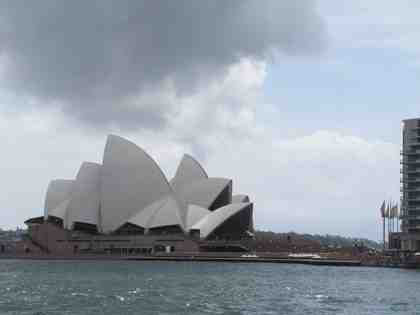

In [ ]:
img = images_Arr[1000]
img

**TRAIN-TEST Split**

In [ ]:
images_train = images_Arr[:7500]
images_test = images_Arr[7500:]

**Extracting Features from all normal (without any preprocessing filters) images in database using VGG16 model**

(Run only if features file is not generated)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from pathlib import Path
from PIL import Image

#Using VGG-16 as the CNN architecture and ImageNet for the weight
base_vgg16_model = VGG16(weights='imagenet')

#We have to get features from fully-connected layer, hence customizing model for the same
cnn_model = Model(inputs=base_vgg16_model.input, outputs=base_vgg16_model.get_layer('fc1').output)

553476096/553467096 [==============================] - 5s 0us/step


**ONLY RUN IF feature file is not extracted**

In [ ]:
#Intializing a features array to store features of all images
features_Arr = []

#Iterating over each image in database to obtain features
for i in range(0, len(images_train)):

  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  images_train_curr = images_train[i].resize((224, 224))
  images_train_curr = images_train_curr.convert('RGB')

  # Reformat and preprocessing the image
  img = image.img_to_array(images_train_curr)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  # Extracting features of current index image
  feature = cnn_model.predict(img)[0]
  feature_norm = np.linalg.norm(feature)
  feature /= feature_norm

  # Appeding the features of current index image in features array
  features_Arr.append(feature)


feature_path = "features.npy"
np.save(feature_path, features_Arr)

#For saving in Gdrive
feature_path = "/content/drive/My Drive/data/features_VGG16.npy"
np.save(feature_path, features_Arr)

Function to plot similar images along with their respective distance from the query image passed in an array/list

In [ ]:
def plot_images(num_images, similar_images):

  #Displaying Similar Images with the distance metric
  axes=[]
  figure = plt.figure(figsize=(18,14), edgecolor='black')

  for i in range(num_images):
      axes.append(figure.add_subplot(4, 5, i+1))
      rank = 'Rank-' + str(i+1)
      axes[-1].set_title(rank + '\nScore: '+ str(similar_images[i][0]))  
      plt.imshow(similar_images[i][1])
      plt.axis('off')
  
  figure.tight_layout()
  plt.show()

Evaluation Metric Calculaion functions (Euclidean Distance and Cosine Similarity)

In [ ]:
#Euclidean distance between features of each image in database with the query image
def euclidian_dist(features, query_feature):
  euclidean_dists = np.linalg.norm(features - query_feature, axis=1)
  return euclidean_dists

#Cosine Similarity between features of each image in database with the query image
def cosine_similarity(features, query_feature):
  cosine_similarity_scores = features.dot(query_feature) / (np.linalg.norm(features, axis=1) * np.linalg.norm(query_feature))
  return cosine_similarity_scores

#Manhattan distance between features of each image in database with the query image
def manhattan_dist(features, query_feature):
  manhattan_dists = []
  for i in range(len(features)):
    manhattan_dists.append(cityblock(features[i], query_feature))
  return np.array(manhattan_dists)

Defining a function to predict similar images based on similarity

In [ ]:
def predict_similar_images(index, num_images, eval_metric):

  #Displaying query Image first
  print("Query Image :")
  query_img = images_test[index]
  display(query_img)
  print('--------------------------------\n')

  #extracting features of query file
  # Resizing the image for VGG16 model architecture, and also converting the color space of image
  query_img = query_img.resize((224, 224))
  query_img = query_img.convert('RGB')

  # Reformat and preprocessing the image
  img = image.img_to_array(query_img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  # Extracting features of current index image
  query_feature = cnn_model.predict(img)[0]
  query_feature_norm = np.linalg.norm(query_feature)
  query_feature /= query_feature_norm

  features_file_path = "/content/drive/My Drive/data/features_VGG16.npy"
  features = np.load(features_file_path)

  #Computing similarity/distances between query image and all images based on extracted features
  #Also sorting resultant metrics to get top k similar images
  if eval_metric == 'cosine':
    metric = cosine_similarity(features, query_feature)
    similar_images_index = np.flip(np.argsort(metric))[:num_images]
  elif eval_metric == 'manhattan':
    metric = manhattan_dist(features, query_feature)
    similar_images_index = np.argsort(metric)[:num_images]
  else:
    metric = euclidian_dist(features, query_feature)
    similar_images_index = np.argsort(metric)[:num_images]

  similar_images = []
  for i in similar_images_index:
    similar_images.append((round(metric[i],5), images_train[i]))

  #Displaying Similar Images with the distance metric
  print('Similar Images')
  plot_images(num_images, similar_images)


Interactive code to precit similar landmark images

In [ ]:
index = int(input("Enter Input Index: "))
num_images = int(input("Enter Number of Similar Images to be predicted (Upto 20): "))

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON MANHATTAN DISTANCE' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'manhattan')

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON EUCLIDEAN DISTANCE' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'euclidean')

print('\n')
print('------------------------------------------------------------------------')
print('\033[1m' + '\t SIMILAR IMAGES BASED ON COSINE SIMILARITY' + '\033[0m')
print('------------------------------------------------------------------------')
predict_similar_images(index, num_images, 'cosine')